<a href="https://colab.research.google.com/github/jaideep11061982/ObjectDetection/blob/master/baseline_fastai_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install fastai

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!pip install tifffile

In [0]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import tifffile as tiff

In [0]:
from tqdm import tqdm
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.data_block import *
from fastai.vision.data import SegmentationProcessor
from fastai.utils.collect_env import show_install

In [0]:
!git clone https://github.com/rafaelpadilla/Object-Detection-Metrics
!git clone https://github.com/ChristianMarzahl/ObjectDetection
  
import sys
sys.path.append("Object-Detection-Metrics/lib")
sys.path.append("ObjectDetection")

fatal: destination path 'Object-Detection-Metrics' already exists and is not an empty directory.
fatal: destination path 'ObjectDetection' already exists and is not an empty directory.


In [0]:
!ls

ObjectDetection  Object-Detection-Metrics  sample_data


In [0]:
from callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from helper.object_detection_helper import *
from loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from models.RetinaNet import RetinaNet

In [0]:
show_install()



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.52
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
Object-Detection-Metrics/lib
ObjectDetection
Object-Detection-Metrics/lib
ObjectDetection
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to e

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import requests

# Download the needed record files and inference files
record_files = {
                  '1F_ZnSh4rtIswInpODHEqHdCde1FFfnPk': 'images_training.tiff', #Train
                  '1etvLe750JV_DqWMM3wdtHP46eMnfQfC-': 'images_test.tiff',
                  '16ZmuBpbmvk8kV4mm9KWcbr1nTfUhC86f': 'descriptions_training.csv',
                  '1XzSsQV3cwaZ_MOwAu2IHB1KhaeFF7oxG': 'Annotations.json'
               } 

for key, value in record_files.items(): 
  print(key)
  file_id = key
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(value)

1F_ZnSh4rtIswInpODHEqHdCde1FFfnPk
1etvLe750JV_DqWMM3wdtHP46eMnfQfC-
16ZmuBpbmvk8kV4mm9KWcbr1nTfUhC86f
1XzSsQV3cwaZ_MOwAu2IHB1KhaeFF7oxG


In [0]:
class Container():

    def __init__(self, image, id):

        self.shape = image.shape[:2]
        self.scan = image
        self.id = id

    def get_image(self):
        return self.scan

In [0]:
class MyImageItemList(ObjectItemList):

    def open(self, fn: Container):
        image = fn.get_image()
        return Image(pil2tensor(image / 255., np.float32))

In [0]:
path = Path(".")
images_path = "images_training.tiff"
test_images_path = "images_test.tiff"
csv_path = "descriptions_training.csv"
scan = tiff.imread(str(path/images_path))
test_scan = tiff.imread(str(path/test_images_path))

descriptions = pd.read_csv(str(path/csv_path), header=None,
                           names = ["nb_spots",
                                    "x_first_spot", "y_first_spot",
                                    "x_second_spot", "y_second_spot"])

### Watch out  uncomment '#[:10000] ' to use all images! 

In [0]:
container_list = []
for element in tqdm(range(len(scan[:10000]))):   

    spot1 = descriptions.iloc[element, 1:3].values
    spot2 = descriptions.iloc[element, 3:5].values

    if spot1[0] > 0:
        image = scan[element, :, :, :]
        container_list.append(Container(image, element))

100%|██████████| 10000/10000 [00:05<00:00, 1771.68it/s]


0


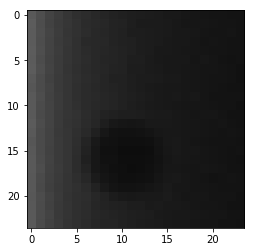

In [0]:
print(container_list[0].id)
plt.imshow(container_list[1].get_image())

In [0]:
container_list_test = []
for element in tqdm(range(len(test_scan))):
    image = test_scan[element, :, :, :]
    container_list_test.append(Container(image, element))

100%|██████████| 144994/144994 [00:00<00:00, 307997.11it/s]


In [0]:
import json

with open(str(path/'Annotations.json')) as json_file:  
    json_data = json.load(json_file)

In [0]:
json_data.keys()

dict_keys(['categories', 'images', 'annotations'])

In [0]:
json_data['annotations'][:1]

[{'bbox': [15.877351073068553, 13.573233873021938, 6, 6],
  'category_id': 1,
  'id': 1,
  'image_id': 1}]

In [0]:
images, lbl_bbox = get_annotations(path/'Annotations.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[str(o.id)]

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      #max_rotate=90,
                      max_lighting=0.15,
                      max_zoom=1.2,
                      max_warp=0.2,
                      p_affine=0.75,
                      p_lighting=0.75,
                      #xtra_tfms=xtra_tfms,
                     )

In [0]:
size = 256
bs = 64

data = (MyImageItemList(container_list)
        #Where are the images? -> in container_list
        .split_by_rand_pct(0.1)
        #How to split in train/valid? -> randomly with the default 10% in valid
        .label_from_func(get_y_func)#
        #How to find the labels? -> use get_y_func
        .transform(tfms, tfm_y=True, size=size)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=bs, collate_fn=bb_pad_collate))
        #Finally we convert to a DataBunch and we use bb_pad_collate

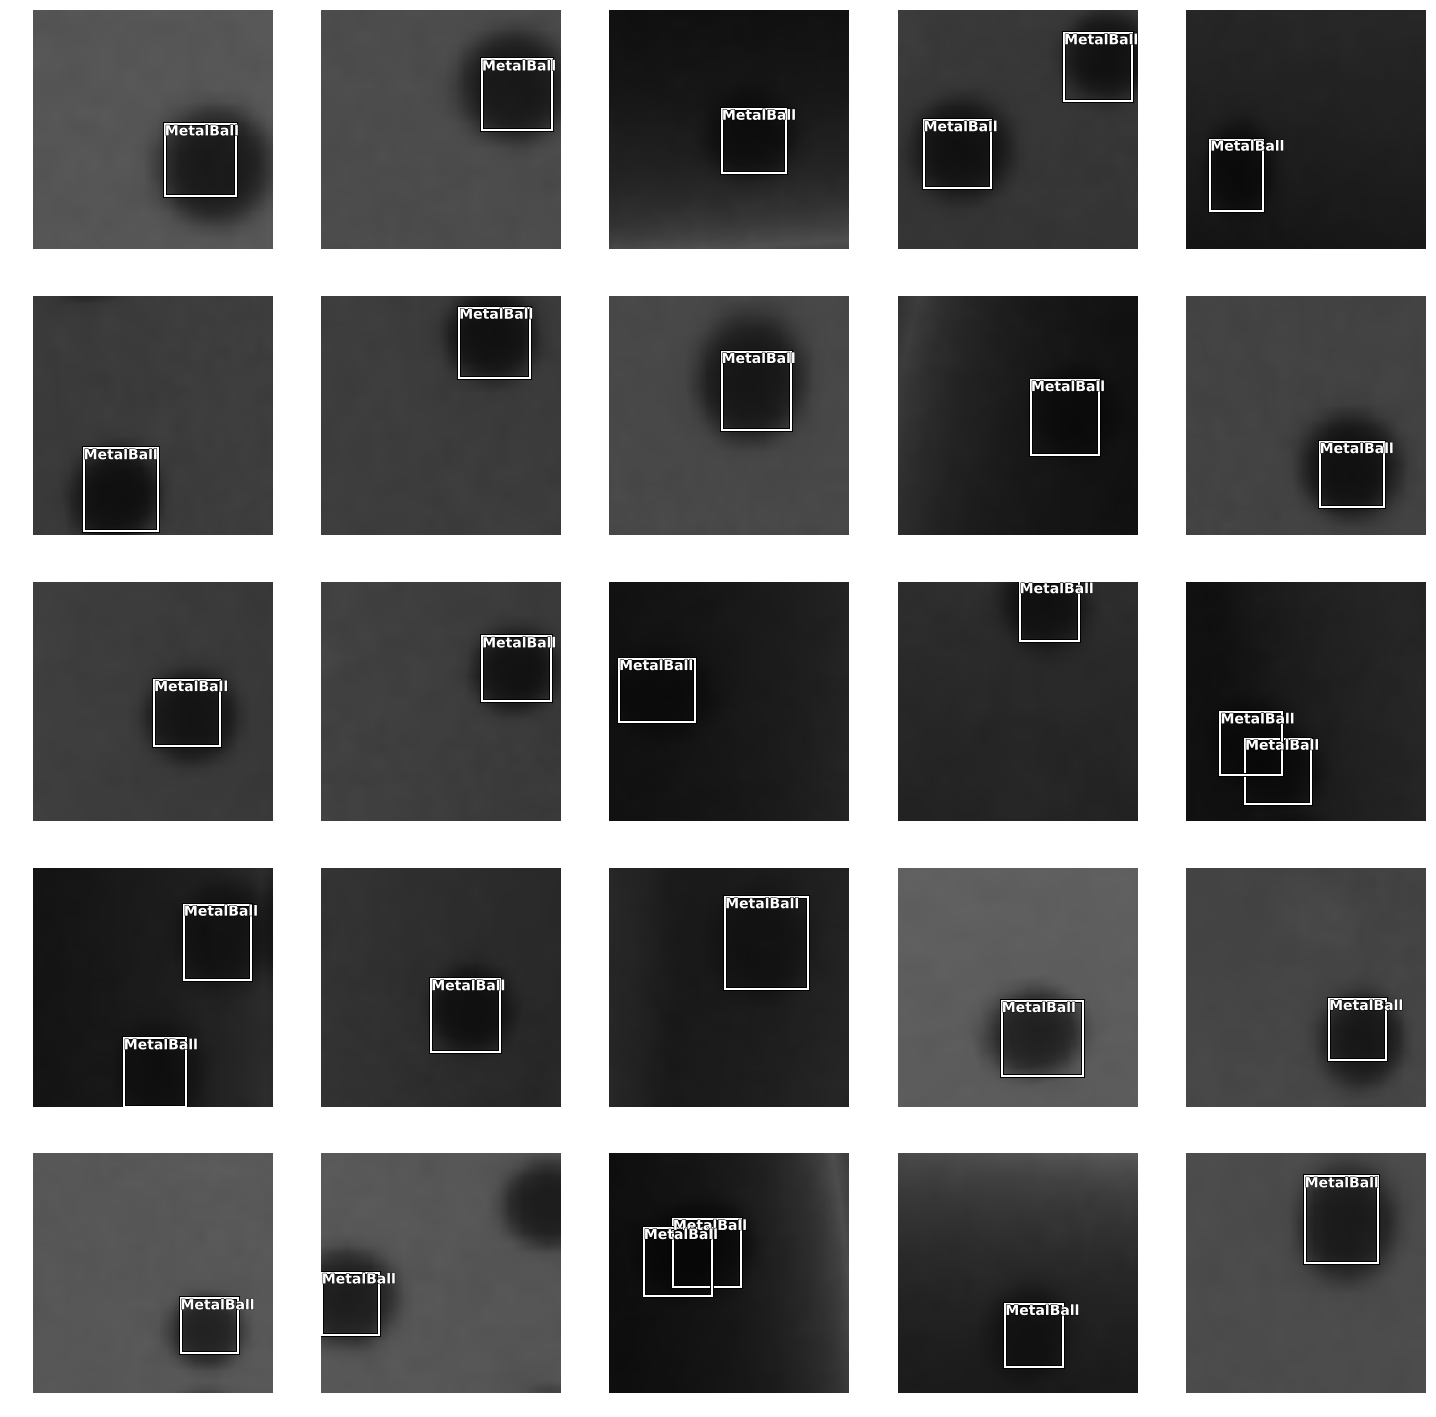

In [0]:
data.show_batch()

In [0]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[2])

In [0]:
anchors.shape

torch.Size([1024, 4])

In [0]:
data.classes

['background', 'MetalBall']

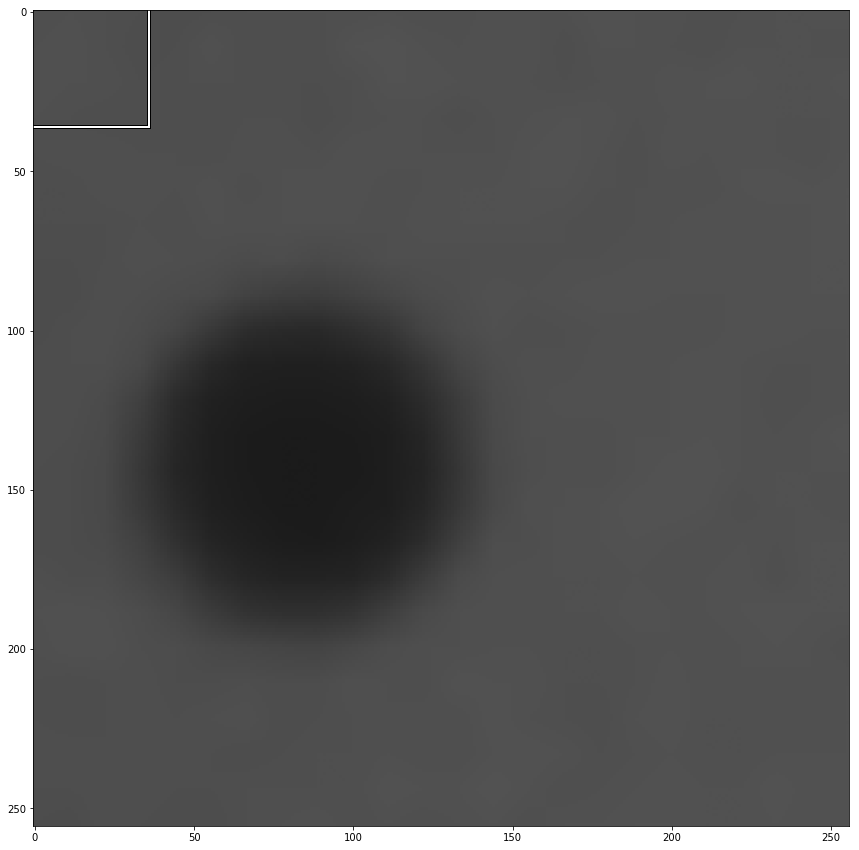

In [0]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[2])


fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[1][0].data))

rect = [0,0,0,0]
for i, bbox in enumerate(anchors[:1]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    x = x - w / 2
    y = y - w / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [0]:
data.train_ds.classes

['background', 'MetalBall']

In [0]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=1, sizes=[32], chs=32, final_bias=-4., n_conv=2)

In [0]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])

In [0]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


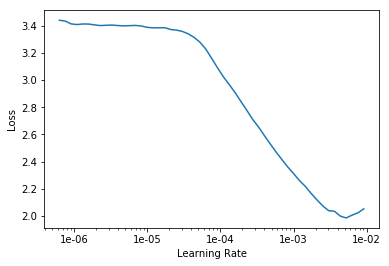

In [0]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-MetalBall,time
0,0.440223,0.293636,0.888825,0.194911,0.098725,0.888825,01:05


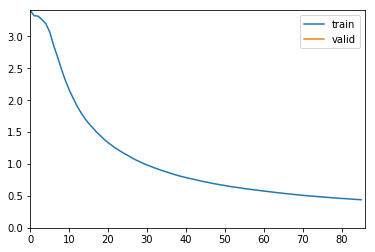

In [0]:
learn.fit_one_cycle(1, 1e-3)

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


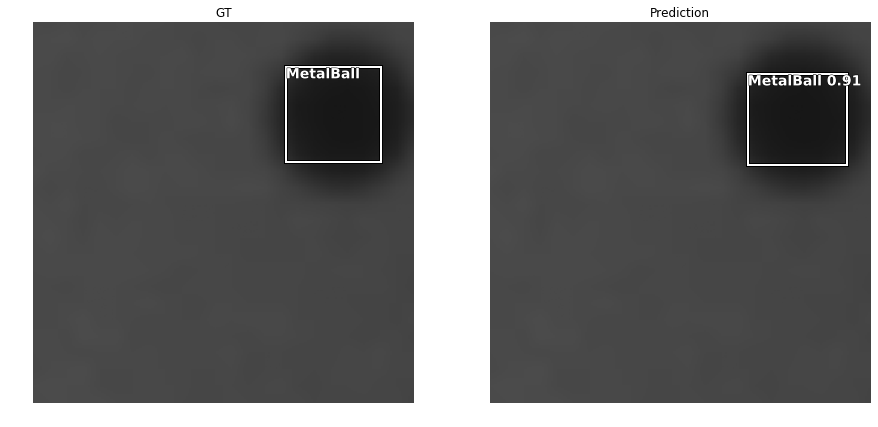

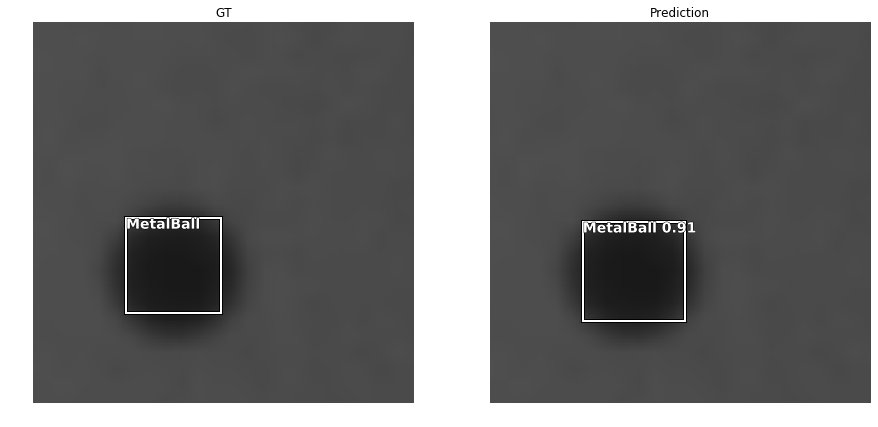

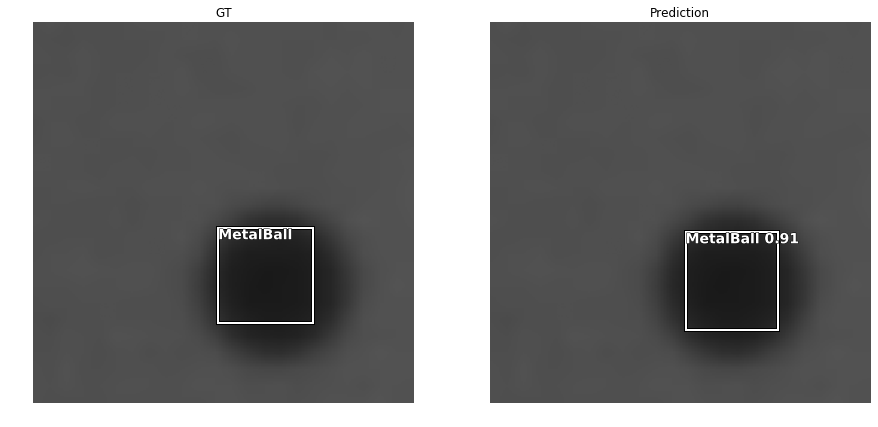

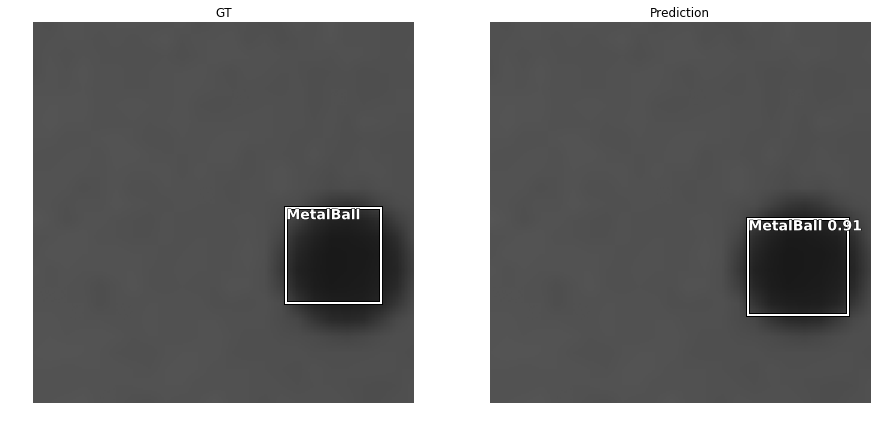

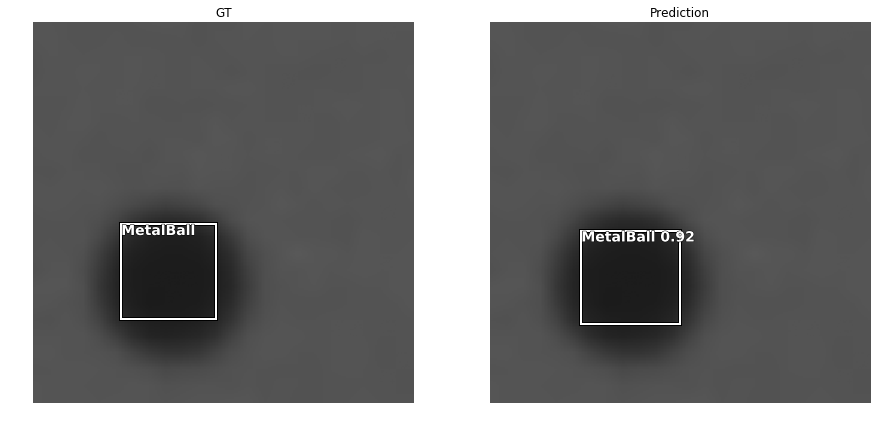

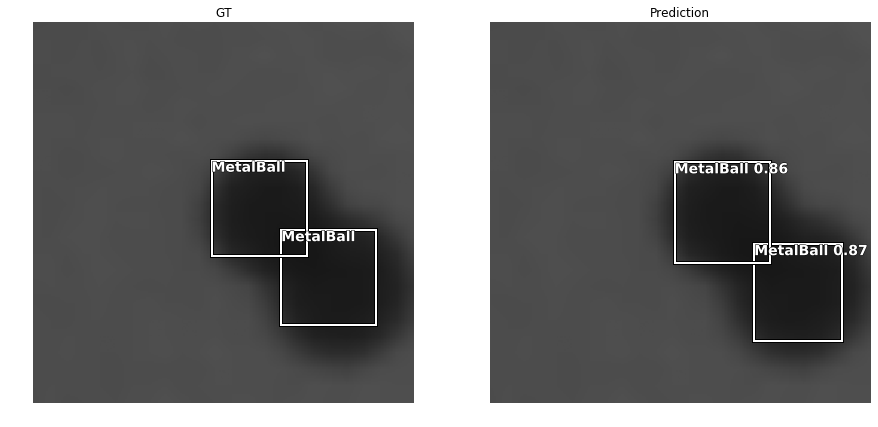

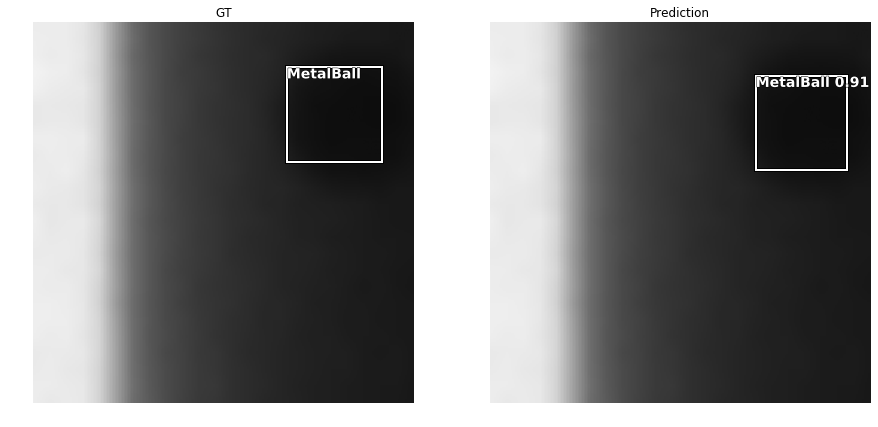

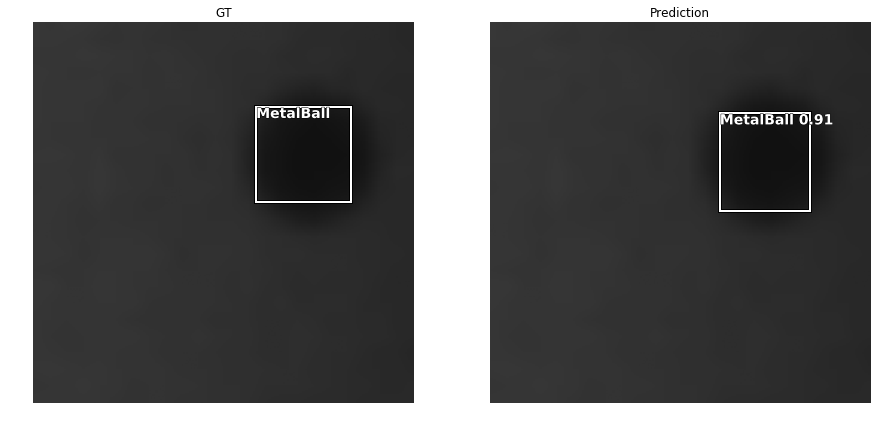

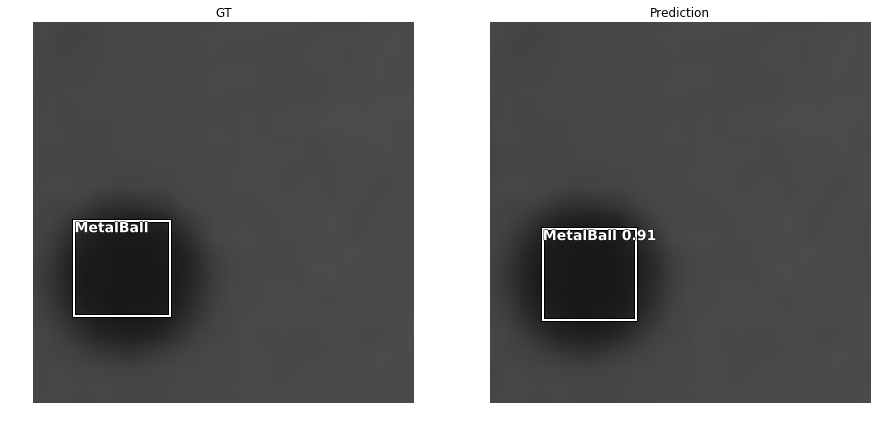

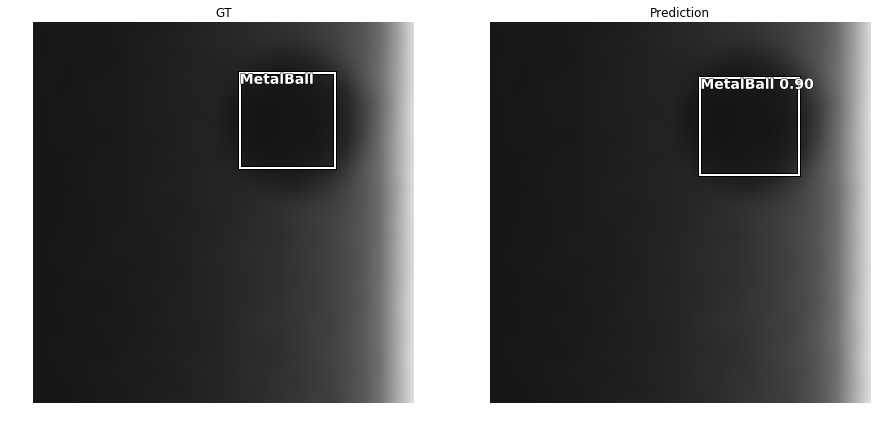

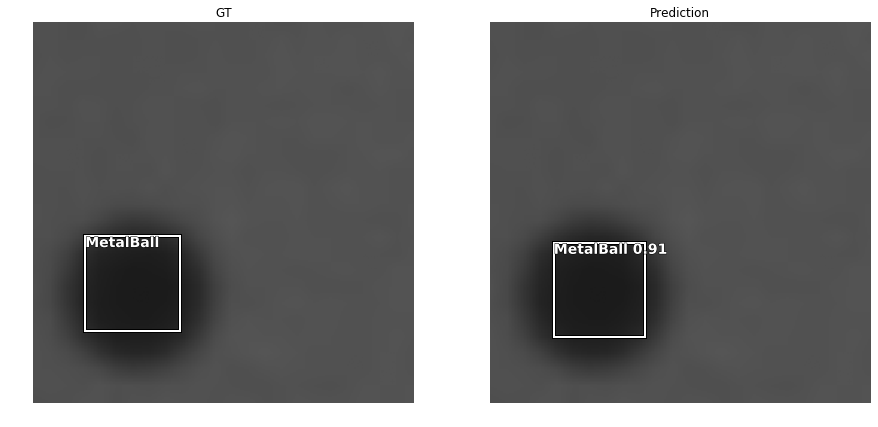

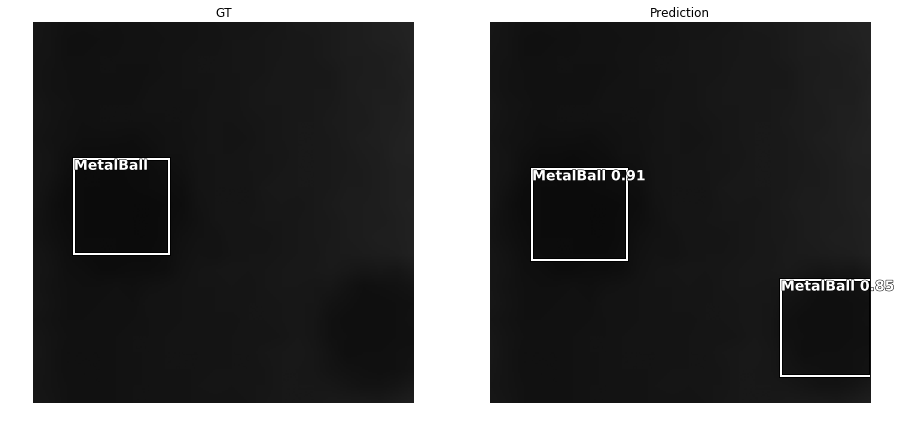

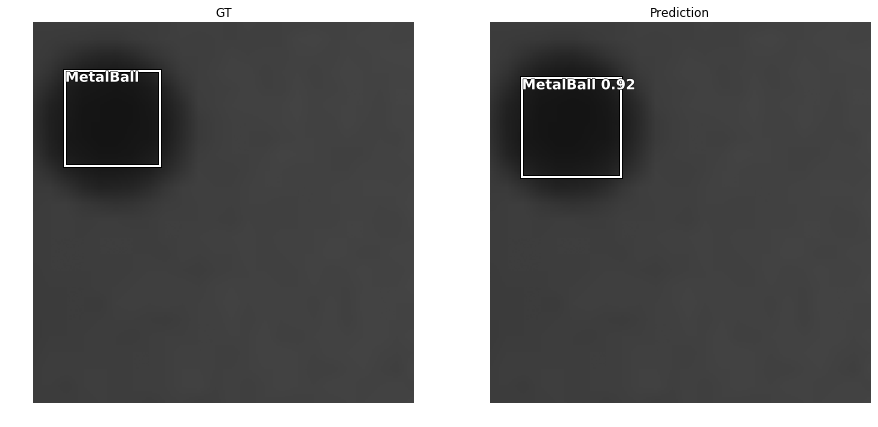

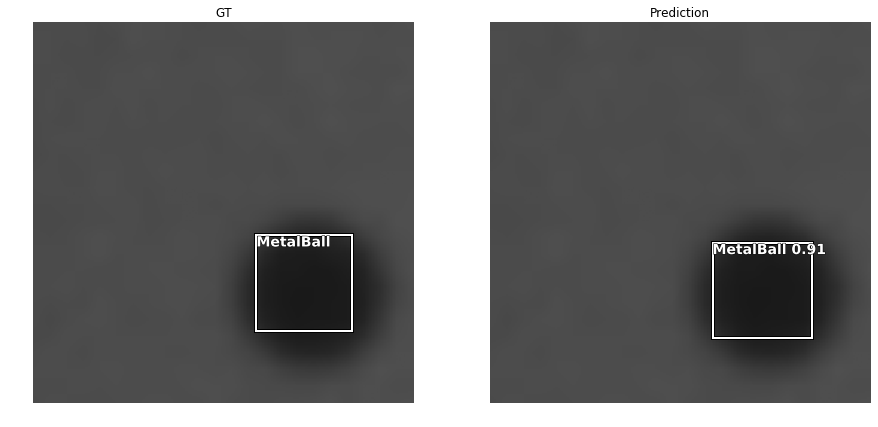

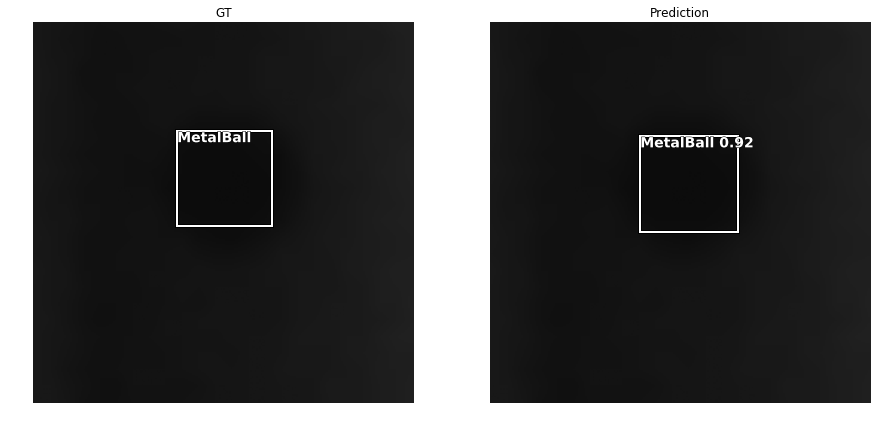

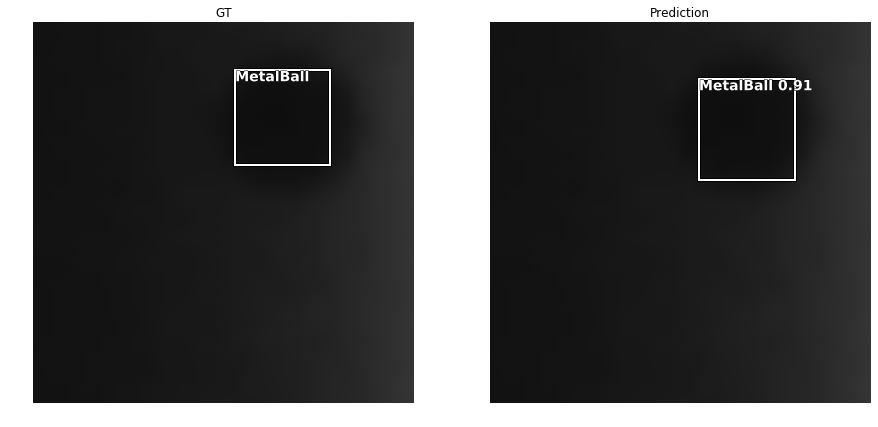

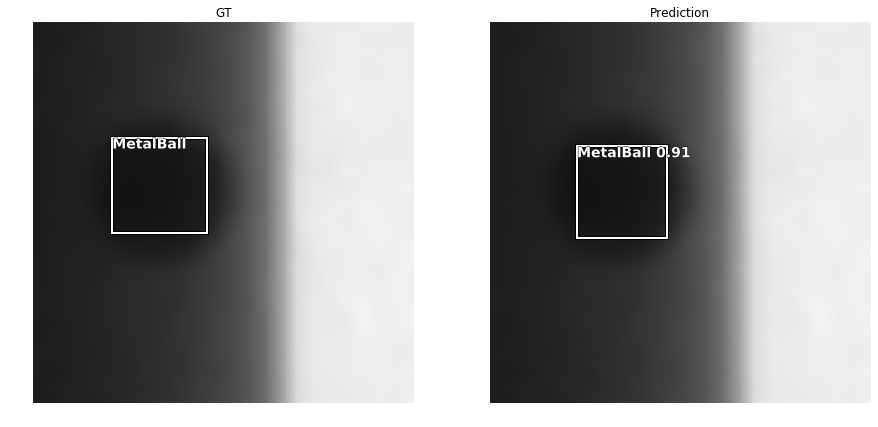

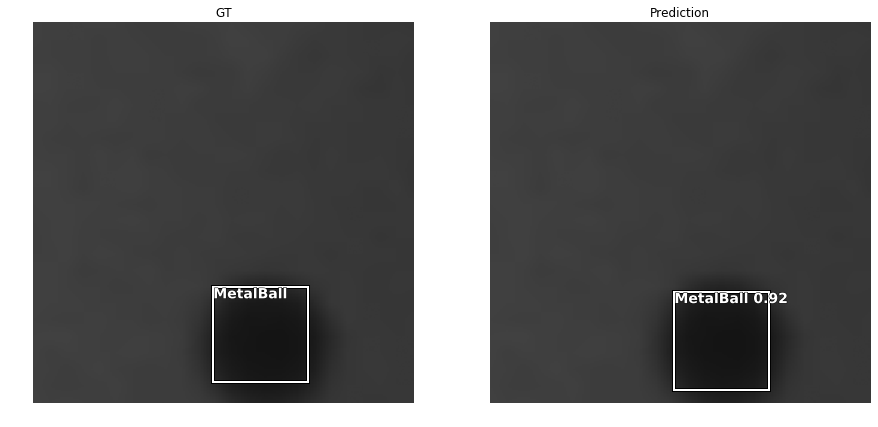

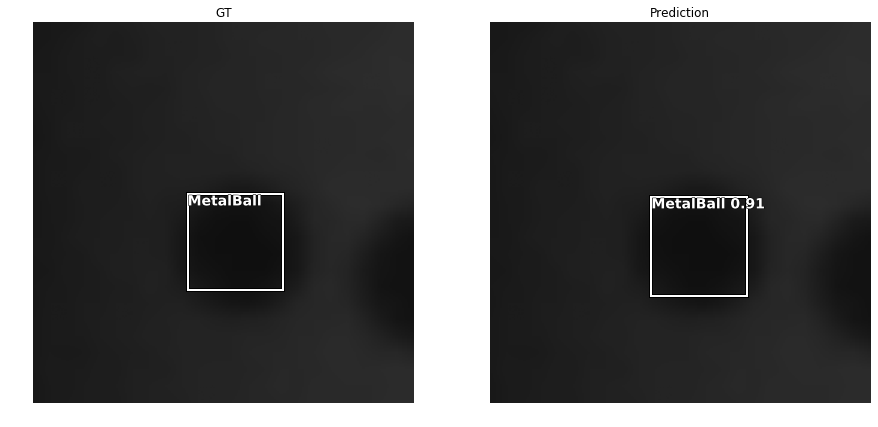

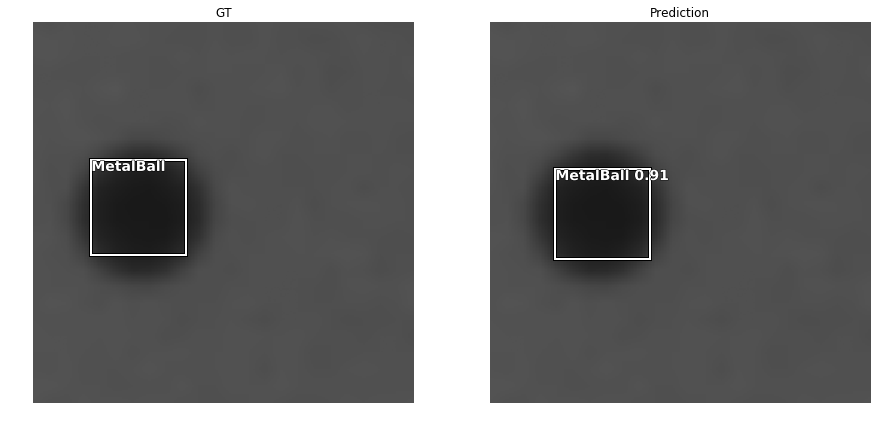

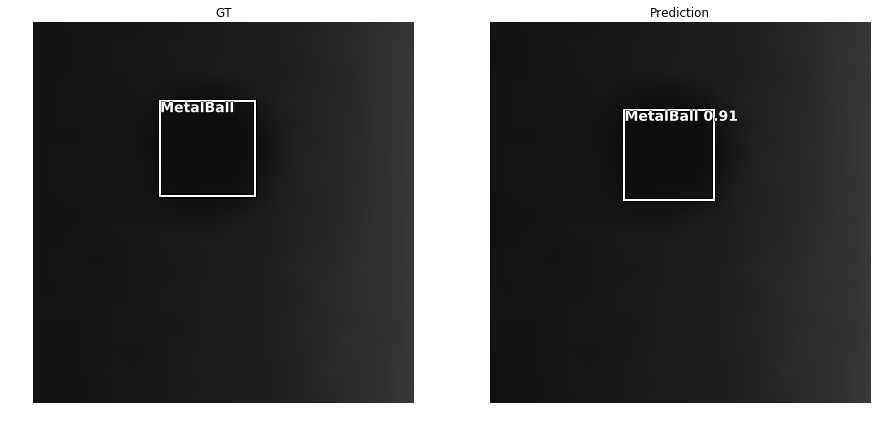

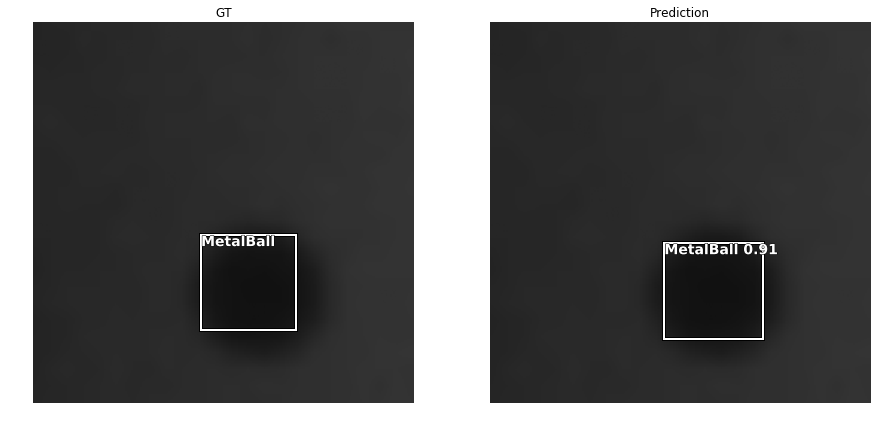

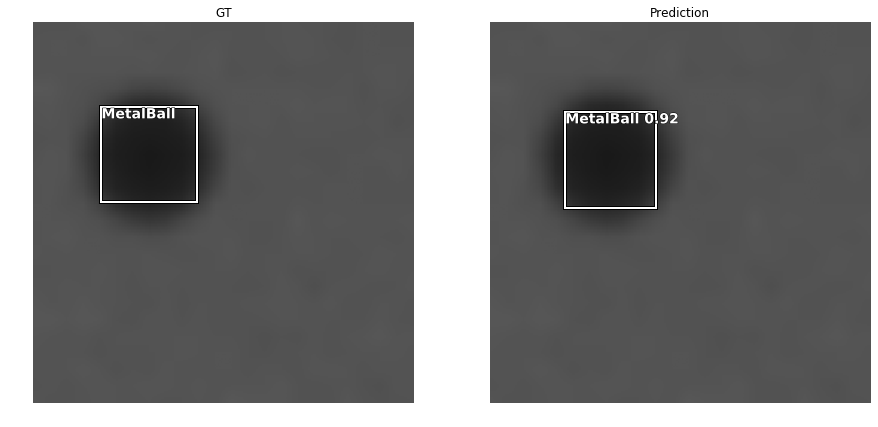

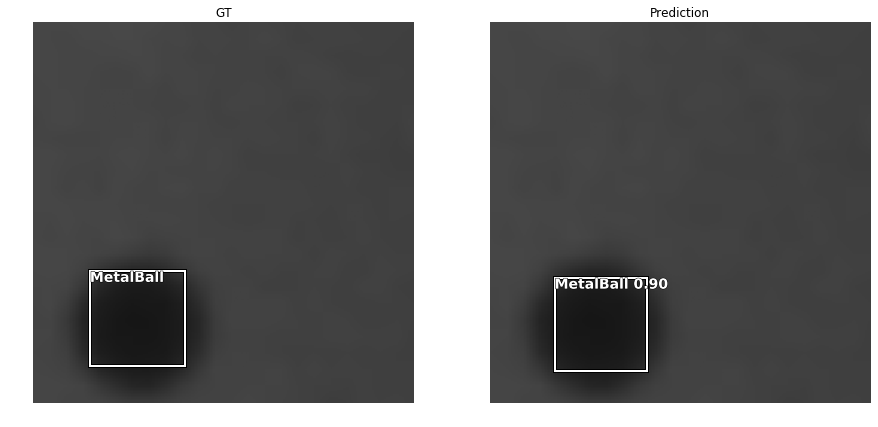

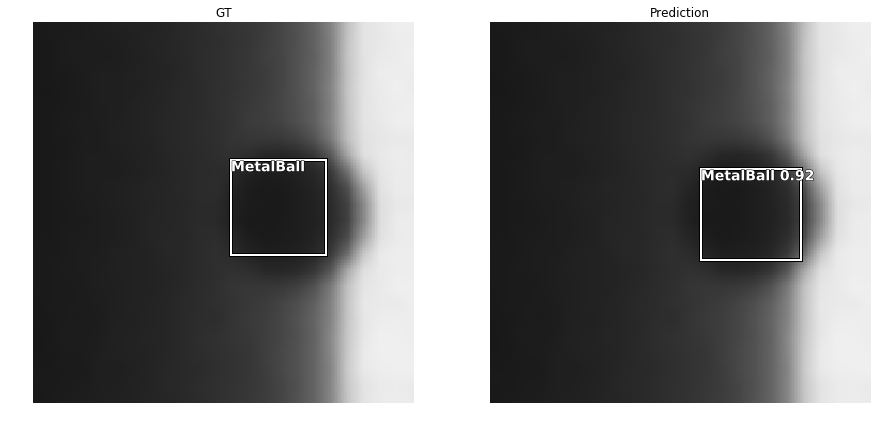

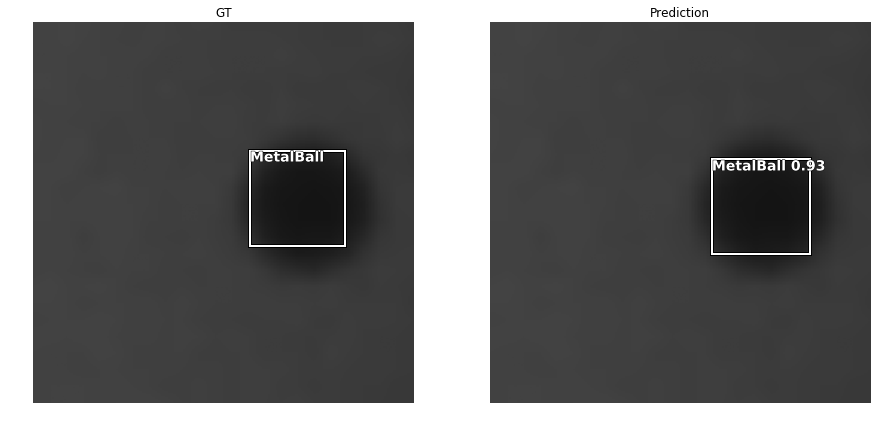

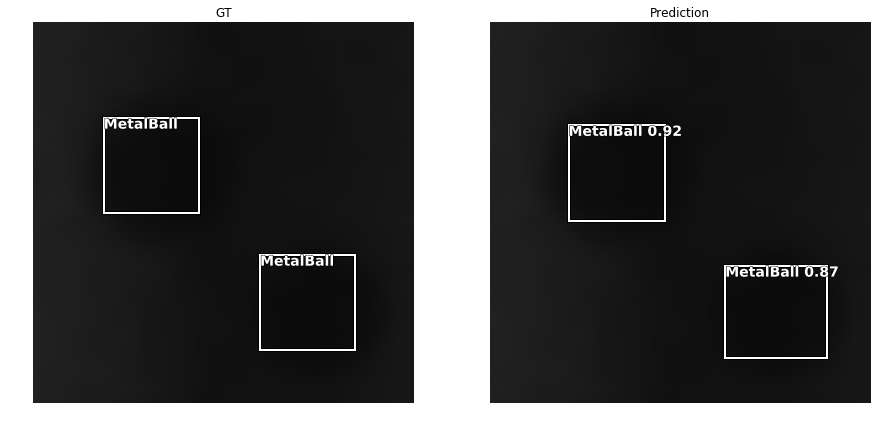

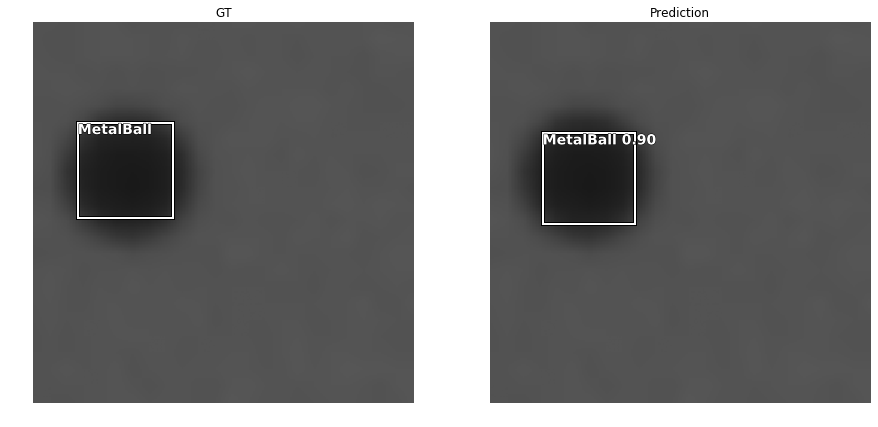

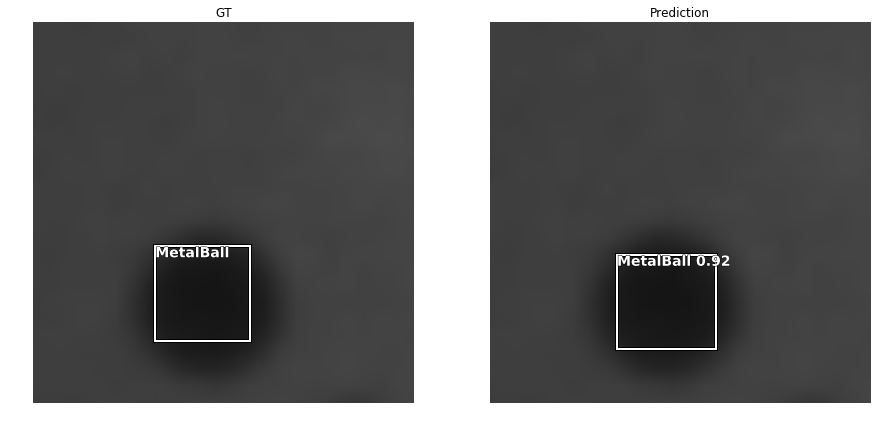

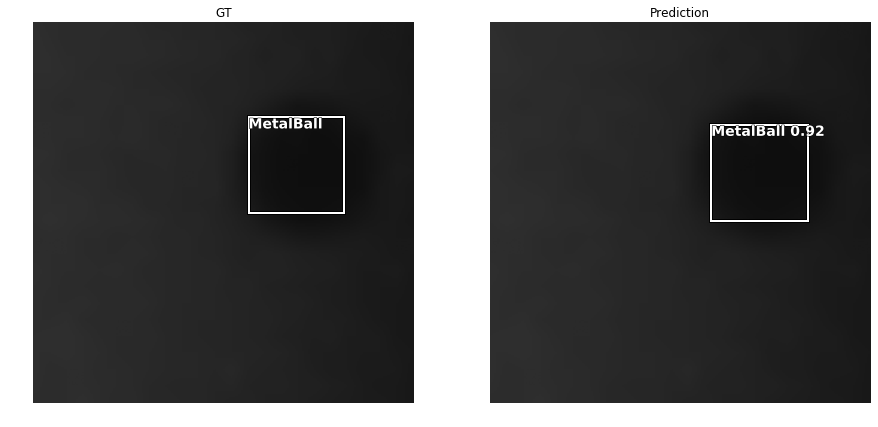

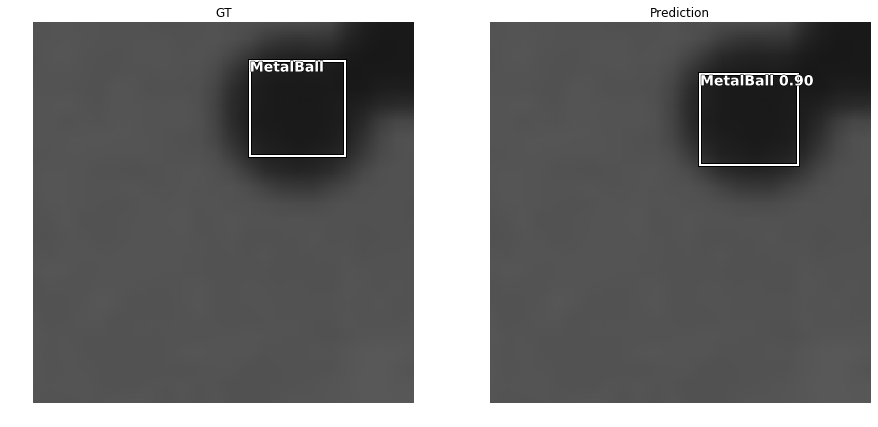

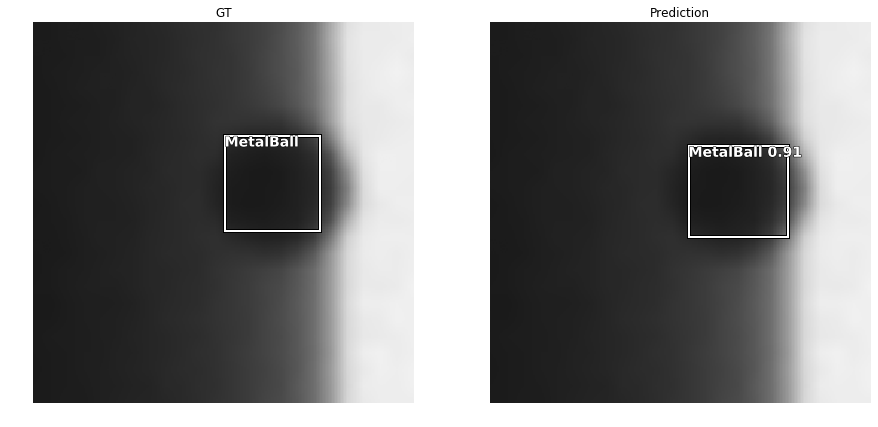

In [0]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.1, image_count=32)

In [0]:
def rescale_box(bboxes, size: Tensor):
    bboxes[:, :2] = bboxes[:, :2] - bboxes[:, 2:] / 2
    bboxes[:, :2] = (bboxes[:, :2] + 1) * size / 2
    bboxes[:, 2:] = bboxes[:, 2:] * size / 2
    bboxes = bboxes.long()
    return bboxes

### Inference example:

In [0]:
detect_thresh = 0.3
nms_thresh = 0.5

nr = []
pos = []
for image_id, test_image in enumerate(tqdm(container_list_test[:100])):
    #mean, std = learn.data.stats

    pos.append([0, 0, 0, 0])
    nr.append(0)

    image_ori = test_image.get_image()
    ori_shape = image_ori.shape[:2]

    image = cv2.resize(image_ori, (size, size))

    image = pil2tensor(image / 255., np.float32).cuda()

    #image = transforms.Normalize(mean, std)(image)

    class_pred_batch, bbox_pred_batch, _ = learn.model(image[None, :, :, :])

    for clas_pred, bbox_pred in zip(class_pred_batch, bbox_pred_batch):
        bbox_pred, scores, preds = process_output(clas_pred, bbox_pred, anchors, detect_thresh)

        if bbox_pred is not None:
            to_keep = nms(bbox_pred, scores, nms_thresh)
            bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()

            t_sz = torch.Tensor(ori_shape)[None].float()
            bbox_pred = rescale_box(bbox_pred, t_sz)

            temp_pos = [0, 0, 0, 0]
            for id, box in enumerate(bbox_pred[:2]):
                x = to_np(box[0] + box[2] / 2)
                y = to_np(box[1] + box[3] / 2)
                if id == 0:
                    temp_pos[ :2] = x,y
                    nr[image_id] = 1
                else:
                    temp_pos[2: ] = x, y
                    nr[image_id] = 2
            pos[image_id] = temp_pos

100%|██████████| 100/100 [00:00<00:00, 132.51it/s]


In [0]:
pos = np.array(pos)
pos = np.maximum(0, pos)
pos = np.minimum(24, pos)

In [0]:
pos.shape

(100, 4)

In [0]:
#Create csv
test_predictions = pd.DataFrame({'nr' : nr,
                                'x0': pos[:,0],
                                'y0': pos[:,1],
                                'x1': pos[:,2],
                                'y1': pos[:,3]})
test_predictions.to_csv("answers.csv", header= False)
test_predictions.head(10)

,nr,x0,y0,x1,y1
0,0,11,5,0,0
1,0,9,18,0,0
2,0,8,16,0,0
3,0,0,0,0,0
4,0,8,19,0,0
5,0,0,0,0,0
6,0,11,10,0,0
7,0,11,17,0,0
8,0,14,12,0,0
9,0,0,0,0,0
